# Customer Service Survey — EDA

This notebook performs exploratory data analysis on `../DATA/customer_service_survey.csv`. It computes summaries, visualizations, group-level statistics (by agent and team), tests for statistical significance, and finishes with a results and conclusions section. Run the cells in order to view plots and tables.

In [1]:
# Imports and load dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr
from matplotlib.ticker import FuncFormatter
sns.set(style="whitegrid")
csv_path = '../DATA/customer_service_survey.csv'
df = pd.read_csv(csv_path)
print('Loaded', csv_path, 'with shape', df.shape)
display(df.head())

Matplotlib is building the font cache; this may take a moment.


Loaded ../DATA/customer_service_survey.csv with shape (150, 27)


,client_id,call_start,call_end,call_duration_min,agent_id,team,topic,resolved,escalation_level,satisfaction_score,...,queue_position,thumbs_up,comments,follow_up_required,language,age,device,contract_type,platform,created_at
0,CID10000,2025-01-15 00:54:00,2025-01-15 01:02:16.405862,8.27,A119,Retention,Billing,1,0,4,...,5.0,NaN,Wait time was too long,0,English,51,Android,Month-to-month,Mobile,2025-10-02 10:56:47.586094
1,CID10001,2025-04-01 00:14:00,2025-04-01 00:18:05.423875,4.09,A192,Technical Support,Connectivity,1,0,7,...,15.0,1.0,NaN,0,English,30,Android,Month-to-month,Mobile,2025-10-02 10:56:47.586094
2,CID10002,2025-02-09 00:08:00,2025-02-09 00:28:51.819872,20.86,A162,Technical Support,Account,1,0,7,...,8.0,1.0,Agent was helpful and resolved my issue quickly,0,English,23,Android,Month-to-month,Mobile,2025-10-02 10:56:47.586094
3,CID10003,2025-01-28 00:29:00,2025-01-28 00:40:48.210848,11.80,A153,Retention,Plan Change,1,0,8,...,10.0,1.0,Excellent support!,0,English,35,Android,1-year,Mobile,2025-10-02 10:56:47.586094
4,CID10004,2025-01-06 00:59:00,2025-01-06 00:59:30.000000,0.50,A173,Technical Support,Technical,1,0,9,...,16.0,1.0,Not happy with the service,0,Other,32,Web,Month-to-month,Landline,2025-10-02 10:56:47.586094


In [2]:
# Auto-generate human-readable descriptions for columns (heuristic)
def describe_columns(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for col in df.columns:
        s = df[col]
        dtype = str(s.dtype)
        n_unique = int(s.nunique(dropna=True))
        n_missing = int(s.isna().sum())
        prop_missing = n_missing / len(df)
        name = col.lower()
        if name in ['agent','agent_id','agentid','agent_name']:
            meaning = 'Agent identifier (who handled the call).'
        elif 'team' in name:
            meaning = 'Team the agent belongs to.'
        elif 'nps' in name or 'promoter' in name:
            meaning = 'Net Promoter Score (0-10) or similar satisfaction metric.'
        elif 'tenure' in name or 'months' in name:
            meaning = 'Tenure in months (customer or agent tenure).'
        elif 'age' in name:
            meaning = 'Age (years).'
        elif 'escalat' in name:
            meaning = 'Escalation level during the call (0/1/2 etc.).'
        elif 'resolv' in name or 'resolved' in name:
            meaning = 'Whether the issue was resolved during the call (boolean/flag).'
        elif 'thumb' in name or 'like' in name or 'up' in name:
            meaning = 'Thumbs-up or positive reaction count/flag.'
        elif 'satisf' in name or 'score' in name:
            meaning = 'Satisfaction score (customer reported).'
        else:
            meaning = ''
        rows.append({
            'column': col,
            'dtype': dtype,
            'n_unique': n_unique,
            'n_missing': n_missing,
            'prop_missing': round(prop_missing, 4),
            'meaning_guess': meaning
        })
    return pd.DataFrame(rows)
col_desc = describe_columns(df)
display(col_desc)

,column,dtype,n_unique,n_missing,prop_missing,meaning_guess
0,client_id,object,150,0,0.0000,
1,call_start,object,147,0,0.0000,
2,call_end,object,150,0,0.0000,
3,call_duration_min,float64,138,0,0.0000,
4,agent_id,object,78,0,0.0000,Agent identifier (who handled the call).
5,team,object,4,0,0.0000,Team the agent belongs to.
6,topic,object,6,0,0.0000,
7,resolved,int64,2,0,0.0000,Whether the issue was resolved during the call...
8,escalation_level,int64,3,0,0.0000,Escalation level during the call (0/1/2 etc.).
9,satisfaction_score,int64,7,0,0.0000,Satisfaction score (customer reported).


Heuristic detection:
agent_col -> agent_id
team_col  -> team
nps_col   -> nps_score
tenure_col-> tenure_months
age_col   -> agent_id
escalation_col -> escalation_level
resolved_col  -> resolved
thumbs_col    -> thumbs_up
satisfaction  -> satisfaction_score


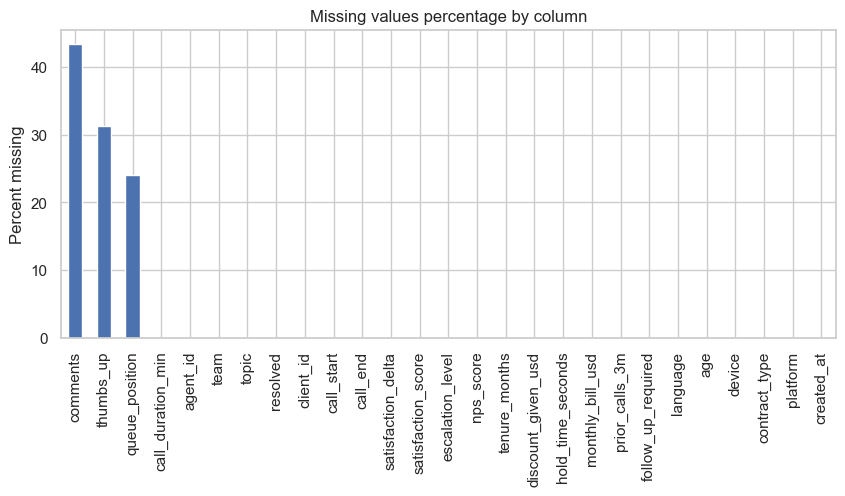

In [3]:
# Helper functions: numeric summary and winsorized mean
import warnings
warnings.filterwarnings('ignore')
def numeric_summary(series: pd.Series):
    s = series.dropna()
    if s.empty:
        return {}
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    n_outliers = int(((s < lower) | (s > upper)).sum())
    return {
        'count': int(s.count()),
        'mean': float(s.mean()),
        'std': float(s.std()),
        'min': float(s.min()),
        '25%': float(q1),
        '50%': float(s.median()),
        '75%': float(q3),
        'max': float(s.max()),
        'n_outliers': n_outliers
    }
from scipy.stats.mstats import winsorize
def winsorized_mean(series, limits=0.05):
    s = series.dropna()
    if len(s) == 0:
        return np.nan
    return winsorize(s, limits=limits).mean()
# Detect likely column names using heuristics
cols = df.columns.tolist()
agent_col = next((c for c in cols if c.lower() in ['agent','agent_id','agentid','agent_name']), None)
team_col = next((c for c in cols if 'team' in c.lower()), None)
nps_col = next((c for c in cols if 'nps' in c.lower() or 'promoter' in c.lower()), None)
tenure_col = next((c for c in cols if 'tenure' in c.lower() or 'months' in c.lower()), None)
age_col = next((c for c in cols if 'age' == c.lower() or 'age' in c.lower()), None)
escalation_col = next((c for c in cols if 'escalat' in c.lower()), None)
resolved_col = next((c for c in cols if 'resolv' in c.lower() or 'resolved' in c.lower()), None)
thumbs_col = next((c for c in cols if 'thumb' in c.lower() or 'like' in c.lower()), None)
sat_col = next((c for c in cols if 'satisf' in c.lower() or 'satisfaction' in c.lower() or 'satisfaction_score' in c.lower()), None)
print('Heuristic detection:')
print('agent_col ->', agent_col)
print('team_col  ->', team_col)
print('nps_col   ->', nps_col)
print('tenure_col->', tenure_col)
print('age_col   ->', age_col)
print('escalation_col ->', escalation_col)
print('resolved_col  ->', resolved_col)
print('thumbs_col    ->', thumbs_col)
print('satisfaction  ->', sat_col)
# Column-level numeric summaries
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
summaries = {c: numeric_summary(df[c]) for c in numeric_cols}
pd.DataFrame.from_dict(summaries, orient='index')
# Missingness plot
plt.figure(figsize=(10,4))
(df.isna().mean() * 100).sort_values(ascending=False).plot(kind='bar')
plt.ylabel('Percent missing')
plt.title('Missing values percentage by column')
plt.show()

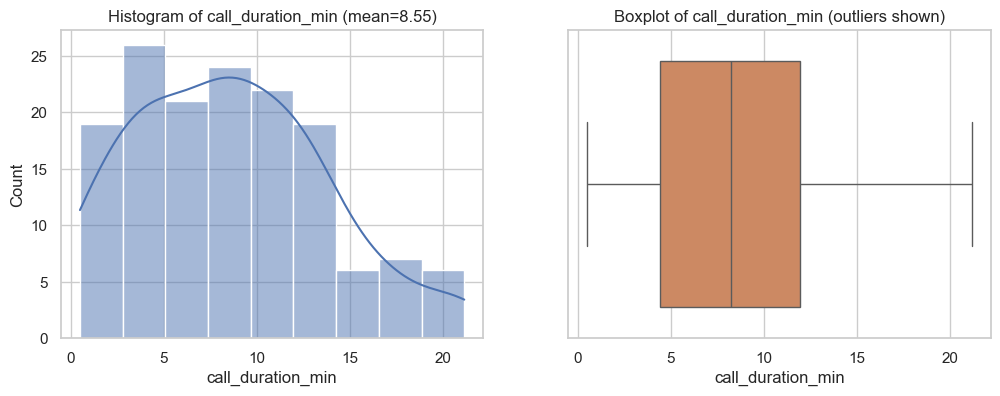

Summary for call_duration_min {'count': 150, 'mean': 8.546666666666667, 'std': 5.193014624941334, 'min': 0.5, '25%': 4.4, '50%': 8.21, '75%': 11.9275, 'max': 21.14, 'n_outliers': 0}


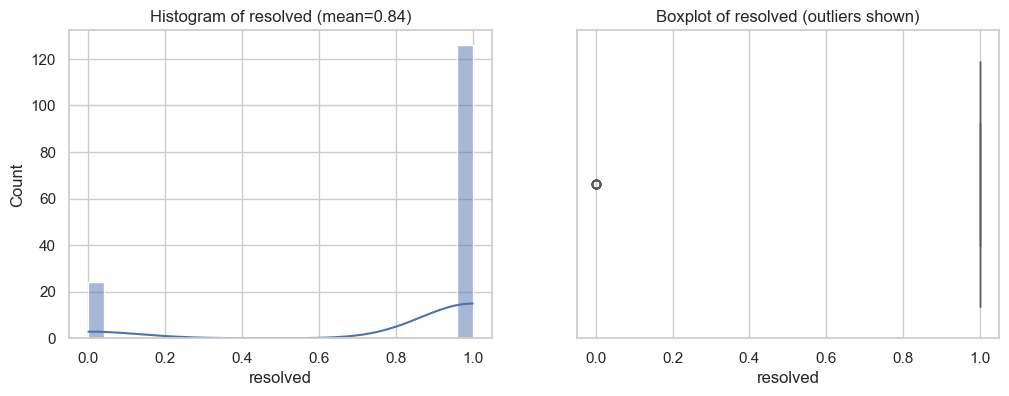

Summary for resolved {'count': 150, 'mean': 0.84, 'std': 0.36783422002692845, 'min': 0.0, '25%': 1.0, '50%': 1.0, '75%': 1.0, 'max': 1.0, 'n_outliers': 24}


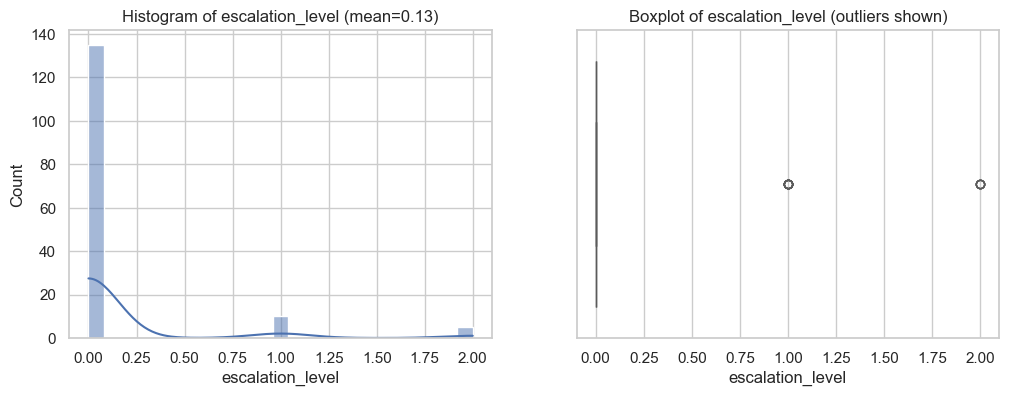

Summary for escalation_level {'count': 150, 'mean': 0.13333333333333333, 'std': 0.42830501999929854, 'min': 0.0, '25%': 0.0, '50%': 0.0, '75%': 0.0, 'max': 2.0, 'n_outliers': 15}


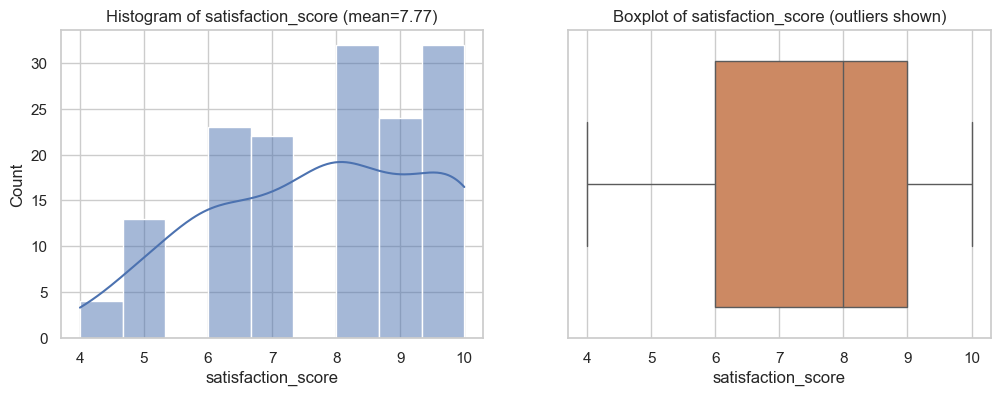

Summary for satisfaction_score {'count': 150, 'mean': 7.766666666666667, 'std': 1.7161556329772518, 'min': 4.0, '25%': 6.0, '50%': 8.0, '75%': 9.0, 'max': 10.0, 'n_outliers': 0}


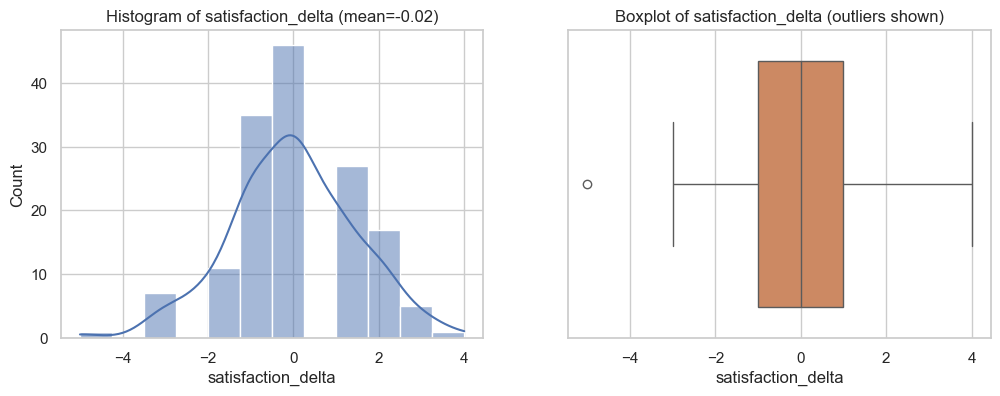

Summary for satisfaction_delta {'count': 150, 'mean': -0.02, 'std': 1.472203297895902, 'min': -5.0, '25%': -1.0, '50%': 0.0, '75%': 1.0, 'max': 4.0, 'n_outliers': 1}


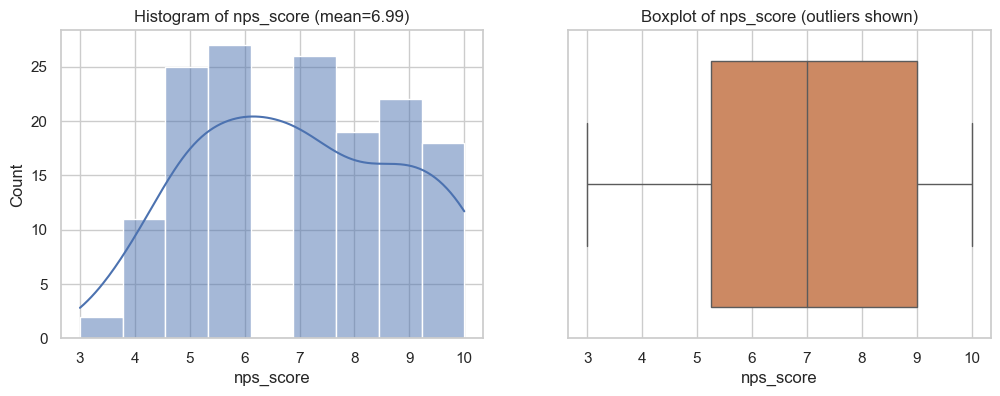

Summary for nps_score {'count': 150, 'mean': 6.993333333333333, 'std': 1.880656270813076, 'min': 3.0, '25%': 5.25, '50%': 7.0, '75%': 9.0, 'max': 10.0, 'n_outliers': 0}


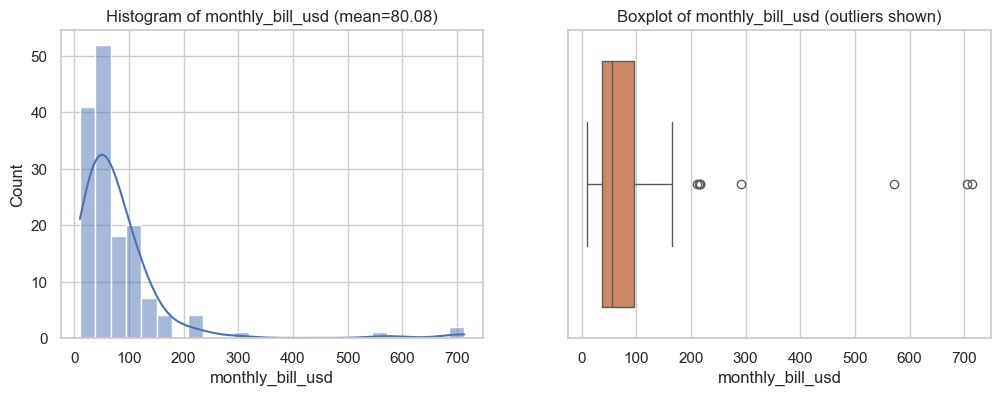

Summary for monthly_bill_usd {'count': 150, 'mean': 80.0838029964226, 'std': 96.1017702121949, 'min': 10.27, '25%': 36.370000000000005, '50%': 55.66, '75%': 96.62, 'max': 713.4429804686824, 'n_outliers': 8}


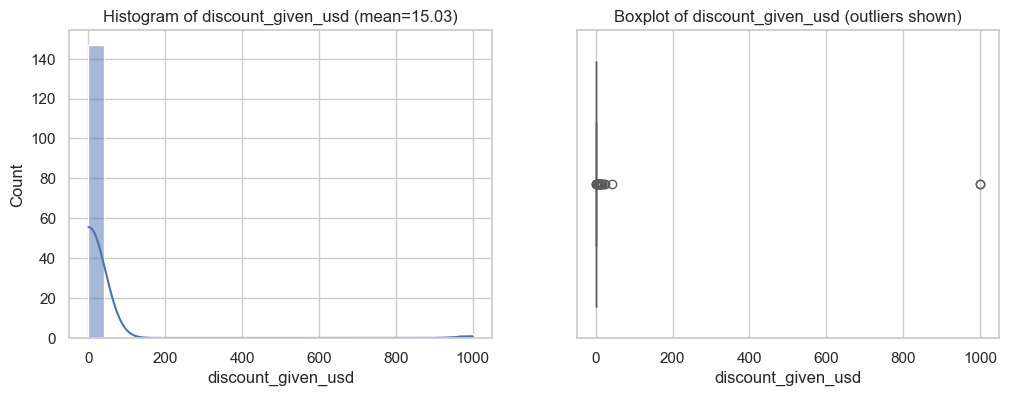

Summary for discount_given_usd {'count': 150, 'mean': 15.025666666666666, 'std': 115.00161313380815, 'min': 0.0, '25%': 0.0, '50%': 0.0, '75%': 0.0, 'max': 999.99, 'n_outliers': 31}


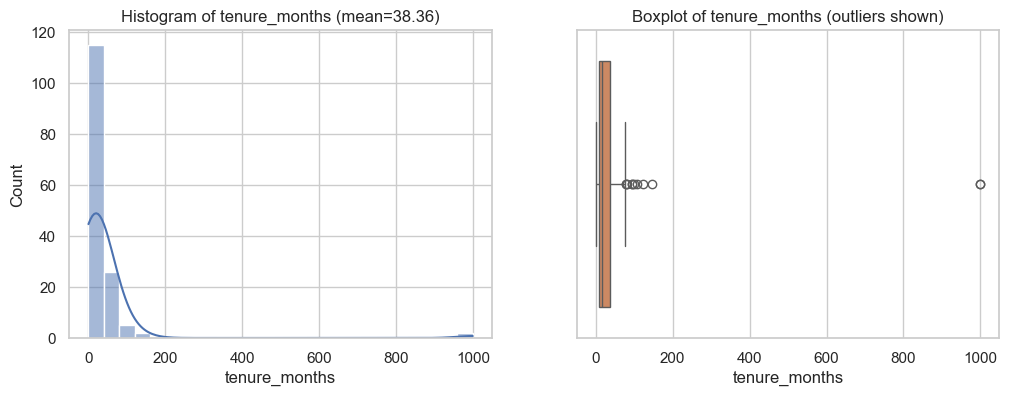

Summary for tenure_months {'count': 150, 'mean': 38.36, 'std': 115.15028289590394, 'min': 0.0, '25%': 8.0, '50%': 16.0, '75%': 36.25, 'max': 999.0, 'n_outliers': 11}


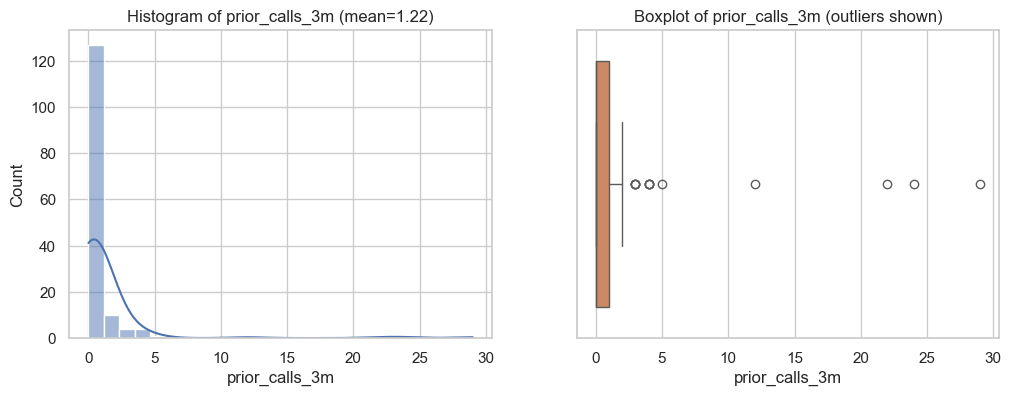

Summary for prior_calls_3m {'count': 150, 'mean': 1.22, 'std': 3.690855741881894, 'min': 0.0, '25%': 0.0, '50%': 0.0, '75%': 1.0, 'max': 29.0, 'n_outliers': 13}


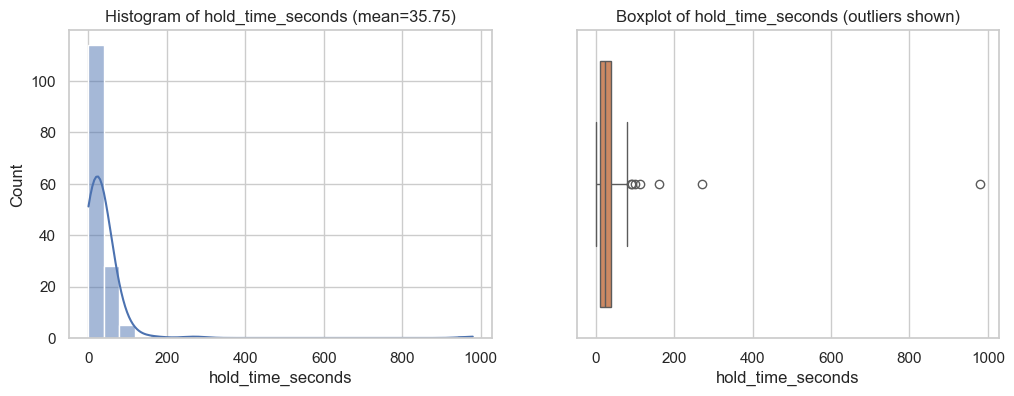

Summary for hold_time_seconds {'count': 150, 'mean': 35.75333333333333, 'std': 83.70641702139258, 'min': 0.0, '25%': 11.0, '50%': 22.5, '75%': 38.75, 'max': 980.0, 'n_outliers': 7}


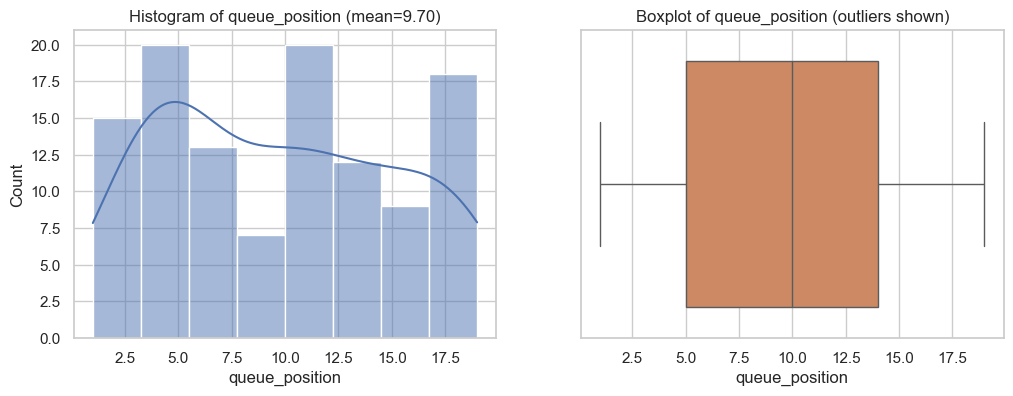

Summary for queue_position {'count': 114, 'mean': 9.701754385964913, 'std': 5.4932457716073, 'min': 1.0, '25%': 5.0, '50%': 10.0, '75%': 14.0, 'max': 19.0, 'n_outliers': 0}


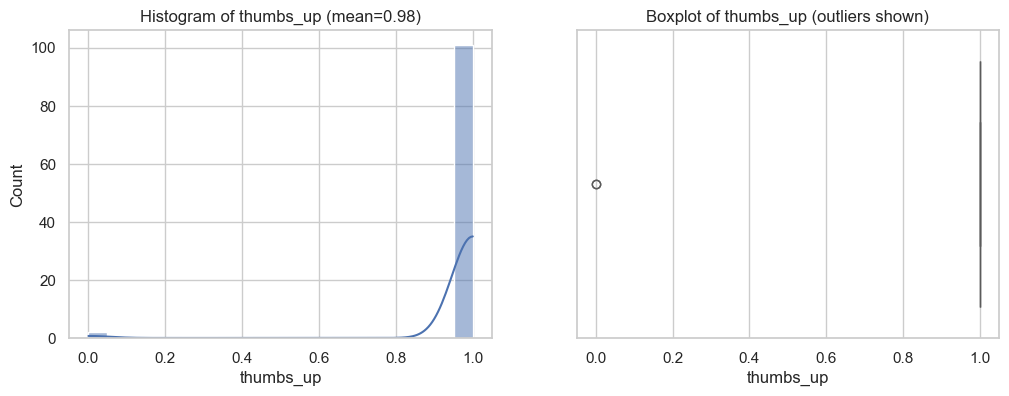

Summary for thumbs_up {'count': 103, 'mean': 0.9805825242718447, 'std': 0.13866184882315602, 'min': 0.0, '25%': 1.0, '50%': 1.0, '75%': 1.0, 'max': 1.0, 'n_outliers': 2}


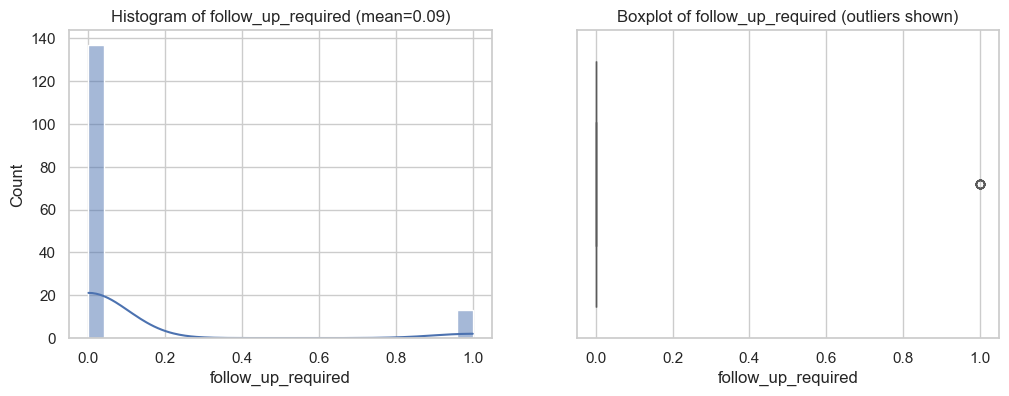

Summary for follow_up_required {'count': 150, 'mean': 0.08666666666666667, 'std': 0.2822885064873428, 'min': 0.0, '25%': 0.0, '50%': 0.0, '75%': 0.0, 'max': 1.0, 'n_outliers': 13}


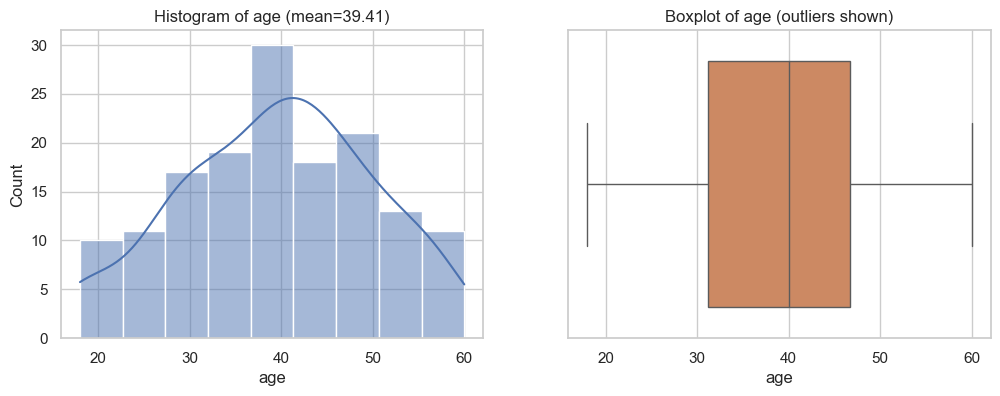

Summary for age {'count': 150, 'mean': 39.406666666666666, 'std': 10.537944648028935, 'min': 18.0, '25%': 31.25, '50%': 40.0, '75%': 46.75, 'max': 60.0, 'n_outliers': 0}


In [4]:
# Histograms and boxplots for numeric columns (showing means and outliers)
for c in numeric_cols:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(df[c].dropna(), kde=True, color='C0')
    plt.title(f'Histogram of {c} (mean={df[c].mean():.2f})')
    plt.subplot(1,2,2)
    sns.boxplot(x=df[c].dropna(), color='C1')
    plt.title(f'Boxplot of {c} (outliers shown)')
    plt.show()
    print('Summary for', c, numeric_summary(df[c]))

In [6]:
# Group summaries: average NPS by agent and team, with counts and SEM
if nps_col is not None:
    if agent_col is not None and agent_col in df.columns:
        agent_stats = df.groupby(agent_col)[nps_col].agg(['count','mean','std']).rename(columns={'count':'n'})
        agent_stats['sem'] = agent_stats['std'] / np.sqrt(agent_stats['n'])
        display(agent_stats.sort_values('n', ascending=False).head(30))
    if team_col is not None and team_col in df.columns:
        team_stats = df.groupby(team_col)[nps_col].agg(['count','mean','std']).rename(columns={'count':'n'})
        team_stats['sem'] = team_stats['std'] / np.sqrt(team_stats['n'])
        # winsorized mean ("discount average by team")
        team_stats['winsorized_mean'] = df.groupby(team_col)[nps_col].apply(lambda x: winsorized_mean(x, limits=0.05))
        display(team_stats.sort_values('n', ascending=False))
else:
    print('No NPS-like column detected; skipping NPS group summaries.')

,n,mean,std,sem
agent_id,,,,
A197,7,8.142857,2.115701,0.799660
A104,5,7.000000,2.121320,0.948683
A139,5,8.000000,1.581139,0.707107
A176,4,6.750000,1.258306,0.629153
A159,4,7.500000,1.290994,0.645497
A187,4,6.250000,1.707825,0.853913
A147,3,5.333333,1.527525,0.881917
A141,3,5.666667,1.527525,0.881917
A144,3,7.333333,1.154701,0.666667


,n,mean,std,sem,winsorized_mean
team,,,,,
Technical Support,57,7.070175,1.771396,0.234627,7.070175
Retention,38,6.552632,1.840936,0.298639,6.552632
Billing,30,7.066667,2.116167,0.386357,7.100000
Sales,25,7.400000,1.870829,0.374166,7.400000


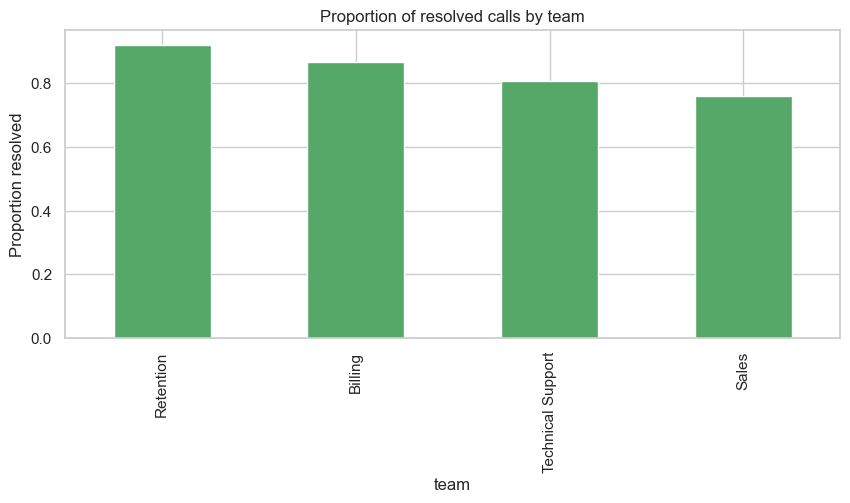

Chi-square for resolved vs team: chi2=3.668, p=0.2996, dof=3
No significant difference in resolved rates across teams (p >= 0.05).


In [7]:
# Proportion of resolved calls by team (and statistical test)
if team_col is not None and resolved_col is not None and team_col in df.columns and resolved_col in df.columns:
    # ensure resolved is numeric 0/1
    resolved_series = pd.to_numeric(df[resolved_col], errors='coerce')
    prop_resolved = df.groupby(team_col)[resolved_col].apply(lambda x: pd.to_numeric(x, errors='coerce').dropna().mean())
    prop_resolved = prop_resolved.fillna(0)
    prop_resolved.sort_values(ascending=False).plot(kind='bar', figsize=(10,4), color='C2')
    plt.ylabel('Proportion resolved')
    plt.title('Proportion of resolved calls by team')
    plt.show()
    # Chi-square test of independence (resolved vs team)
    contingency = pd.crosstab(df[team_col], resolved_series.fillna(0).astype(int))
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f'Chi-square for resolved vs team: chi2={chi2:.3f}, p={p:.4f}, dof={dof}')
    if p < 0.05:
        print('Resolved rates differ significantly across teams (p < 0.05).')
    else:
        print('No significant difference in resolved rates across teams (p >= 0.05).')
else:
    print('Cannot compute resolved-by-team: missing team or resolved column.')

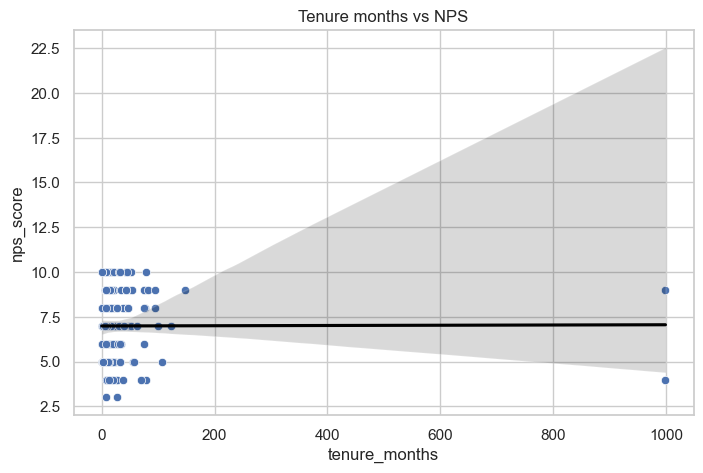

Pearson correlation tenure vs NPS: r=0.004, p=0.9600


In [8]:
# Tenure months vs NPS: scatter, regression, correlation and p-value
if tenure_col is not None and nps_col is not None and tenure_col in df.columns and nps_col in df.columns:
    sub = df[[tenure_col, nps_col]].dropna()
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=sub, x=tenure_col, y=nps_col)
    sns.regplot(data=sub, x=tenure_col, y=nps_col, scatter=False, color='black')
    plt.title('Tenure months vs NPS')
    plt.show()
    corr, pval = pearsonr(sub[tenure_col], sub[nps_col])
    print(f'Pearson correlation tenure vs NPS: r={corr:.3f}, p={pval:.4f}')
    if pval < 0.05:
        print('Correlation is statistically significant (p < 0.05).')
else:
    print('Cannot compute tenure vs NPS: missing columns.')

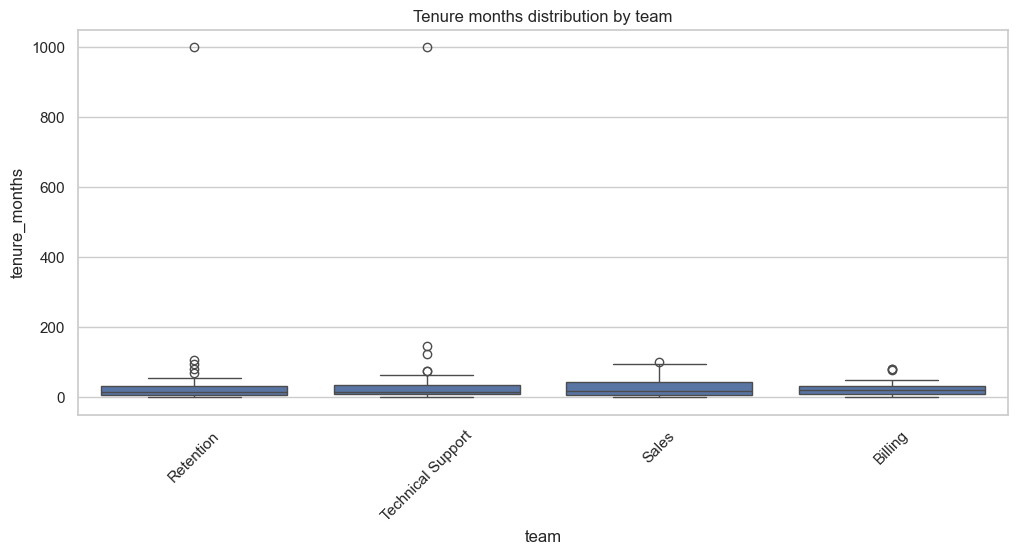

In [9]:
# Tenure distribution by team (boxplot)
if tenure_col is not None and team_col is not None and tenure_col in df.columns and team_col in df.columns:
    plt.figure(figsize=(12,5))
    sns.boxplot(data=df, x=team_col, y=tenure_col)
    plt.xticks(rotation=45)
    plt.title('Tenure months distribution by team')
    plt.show()
else:
    print('Missing tenure or team; skipping tenure-by-team plot.')

DTypePromotionError: The DType <class 'numpy.dtypes._PyFloatDType'> could not be promoted by <class 'numpy.dtypes.StrDType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes._PyFloatDType'>)

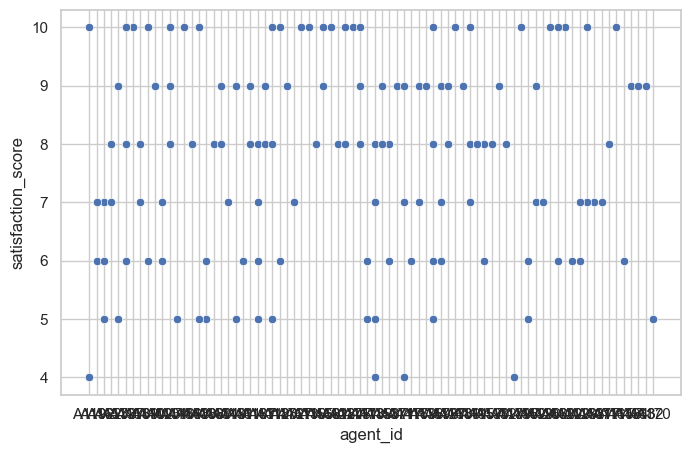

In [10]:
# Age vs Satisfaction (scatter + corr)
if age_col is not None and sat_col is not None and age_col in df.columns and sat_col in df.columns:
    sub = df[[age_col, sat_col]].dropna()
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=sub, x=age_col, y=sat_col)
    sns.regplot(data=sub, x=age_col, y=sat_col, scatter=False, color='black')
    plt.title('Age vs Satisfaction')
    plt.show()
    corr, pval = pearsonr(sub[age_col], sub[sat_col])
    print(f'Pearson correlation age vs satisfaction: r={corr:.3f}, p={pval:.4f}')
    if pval < 0.05:
        print('Correlation is statistically significant (p < 0.05).')
else:
    print('Missing age or satisfaction columns; skipping age-vs-satisfaction analysis.')

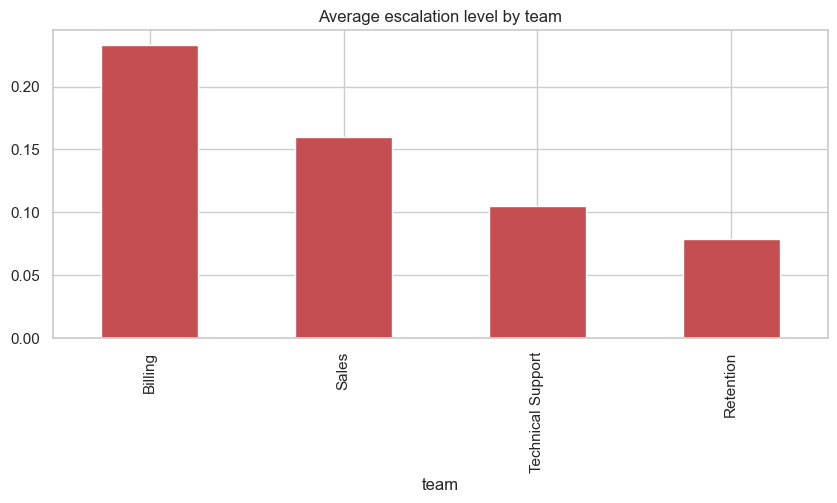

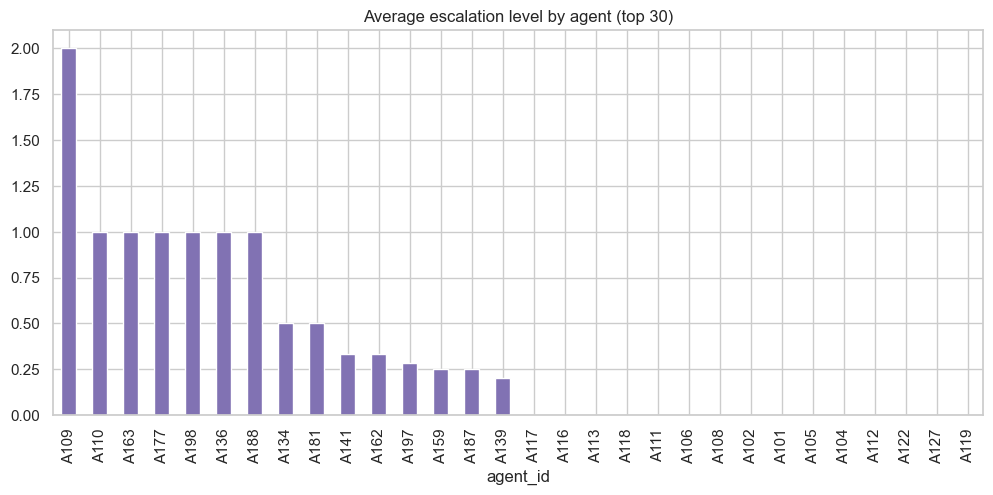

In [11]:
# Escalation level by team and by agent
if escalation_col is not None and escalation_col in df.columns:
    if team_col is not None and team_col in df.columns:
        esc_by_team = df.groupby(team_col)[escalation_col].mean().sort_values(ascending=False)
        esc_by_team.plot(kind='bar', figsize=(10,4), color='C3')
        plt.title('Average escalation level by team')
        plt.show()
    if agent_col is not None and agent_col in df.columns:
        esc_by_agent = df.groupby(agent_col)[escalation_col].mean().sort_values(ascending=False)
        esc_by_agent.head(30).plot(kind='bar', figsize=(12,5), color='C4')
        plt.title('Average escalation level by agent (top 30)')
        plt.show()
else:
    print('No escalation column detected; skipping escalation analysis.')

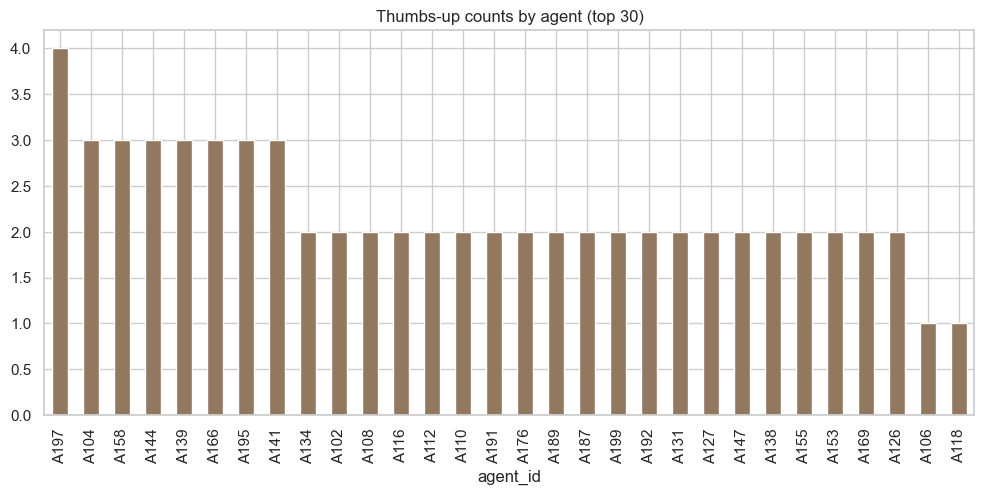

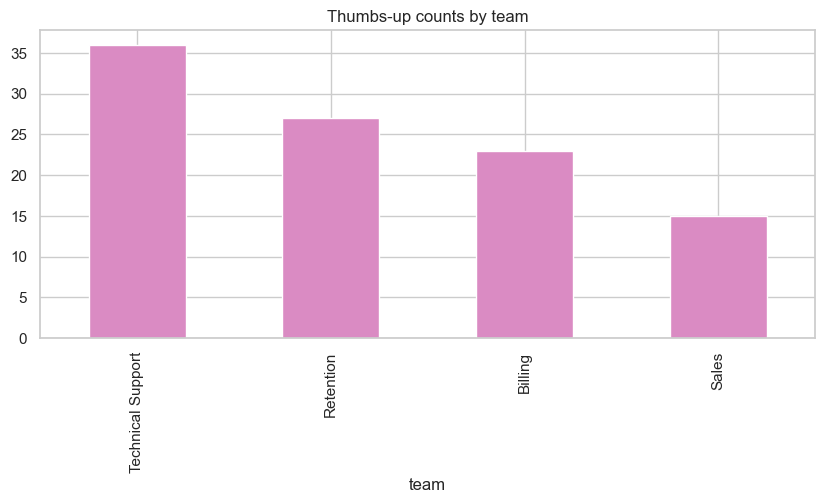

In [12]:
# Thumbs-up counts by agent and team
if thumbs_col is not None and thumbs_col in df.columns:
    if agent_col is not None and agent_col in df.columns:
        thumbs_agent = pd.to_numeric(df[thumbs_col], errors='coerce').fillna(0).groupby(df[agent_col]).sum().sort_values(ascending=False)
        thumbs_agent.head(30).plot(kind='bar', figsize=(12,5), color='C5')
        plt.title('Thumbs-up counts by agent (top 30)')
        plt.show()
    if team_col is not None and team_col in df.columns:
        thumbs_team = pd.to_numeric(df[thumbs_col], errors='coerce').fillna(0).groupby(df[team_col]).sum().sort_values(ascending=False)
        thumbs_team.plot(kind='bar', figsize=(10,4), color='C6')
        plt.title('Thumbs-up counts by team')
        plt.show()
else:
    print('No thumbs-up column detected; skipping thumbs analysis.')

In [13]:
# ANOVA: NPS across teams (statistical significance)
if nps_col is not None and team_col is not None and nps_col in df.columns and team_col in df.columns:
    groups = [g.dropna() for _, g in df.groupby(team_col)[nps_col]]
    if len(groups) > 1:
        fstat, pval = stats.f_oneway(*groups)
        print(f'ANOVA across teams for {nps_col}: F={fstat:.3f}, p={pval:.4f}')
        if pval < 0.05:
            print('There is a statistically significant difference in mean NPS across teams (p < 0.05).')
        else:
            print('No statistically significant difference in mean NPS across teams (p >= 0.05).')
    else:
        print('Not enough groups for ANOVA (need 2+).')
else:
    print('Missing NPS or team column; skipping ANOVA.')

ANOVA across teams for nps_score: F=1.135, p=0.3369
No statistically significant difference in mean NPS across teams (p >= 0.05).


In [16]:
# Final results and conclusions
from textwrap import fill
rows = []
rows.append(f'Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.')
rows.append('Column summary:')
rows.append(col_desc.to_string(index=False))
# Key findings (computed above)
if nps_col is not None and team_col is not None and nps_col in df.columns and team_col in df.columns:
    rows.append('Average NPS by team:')
    rows.append(team_stats.to_string())
    if 'pval' in globals():
        rows.append(f'ANOVA p-value for NPS across teams: {pval:.4f}')
else:
    rows.append('NPS/team analysis not available.')
# Add a short concluding paragraph
rows.append('Conclusions:')
rows.append('Review the plots and tables above for details. The notebook computed means, standard deviations, counts, proportions, winsorized (discounted) team averages, and ran significance tests (ANOVA, chi-square, correlations) where appropriate. Items flagged with p < 0.05 are statistically significant at the 5% level.')
print('--- Results & Conclusions ---')
for r in rows:
    print(fill(str(r), width=120))

--- Results & Conclusions ---
Dataset contains 150 rows and 27 columns.
Column summary:
            column   dtype  n_unique  n_missing  prop_missing
meaning_guess          client_id  object       150          0        0.0000
call_start  object       147          0        0.0000
call_end  object       150          0        0.0000
call_duration_min float64       138          0        0.0000
agent_id  object        78          0        0.0000                       Agent identifier (who handled the call).
team  object         4          0        0.0000                                     Team the agent belongs to.
topic  object         6          0        0.0000
resolved   int64         2          0        0.0000 Whether the issue was resolved during the call (boolean/flag).
escalation_level   int64         3          0        0.0000                 Escalation level during the call (0/1/2
etc.). satisfaction_score   int64         7          0        0.0000                        Satisfact